In [1]:
import tensorflow as tf

2024-07-31 15:13:44.784835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 15:13:44.799219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 15:13:44.803683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 15:13:44.814484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
import os

# Create necessary directories
os.makedirs('dataset_10sec', exist_ok=True)
os.makedirs('Output', exist_ok=True)

In [3]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp(ms)'], unit='ms')
    df = df.sort_values(['VehId', 'DayNum', 'Timestamp'])
    return df

file_path = r'/mnt/sdc/Aditya/VED_POC/cleaned_ev_data/processed_ev_data_3vehicles.csv'  # Replace with your actual file path
df = load_and_preprocess_data(file_path)

In [4]:
import pandas as pd
import numpy as np
from scipy import interpolate

# Assuming your data is in a DataFrame called 'df'

# Sort the DataFrame
df.sort_values(['VehId', 'DayNum', 'Timestamp(ms)'], inplace=True)

# Function to resample data for a single vehicle and day
def resample_vehicle_day(group):
    # Convert Timestamp(ms) to seconds for easier handling
    group['Timestamp(s)'] = group['Timestamp(ms)'] / 1000

    # Calculate the start and end times
    start_time = group['Timestamp(s)'].min()
    end_time = group['Timestamp(s)'].max()

    # Define the desired time interval (10 seconds)
    time_interval = 10  # in seconds

    # Create a new index with 10-second intervals
    new_index = np.arange(start_time, end_time + time_interval, time_interval)

    # Function to resample a column using linear interpolation
    def resample_column(column):
        f = interpolate.interp1d(group['Timestamp(s)'], column, kind='linear', fill_value='extrapolate')
        return f(new_index)

    # Apply resampling to all numeric columns except DayNum and Timestamp(ms)
    resampled_data = {}
    for column in group.select_dtypes(include=[np.number]).columns:
        if column not in ['DayNum', 'Timestamp(ms)', 'Timestamp(s)']:
            resampled_data[column] = resample_column(group[column])

    # Create a new DataFrame with resampled data
    resampled_df = pd.DataFrame(resampled_data, index=new_index)

    # Add back the VehId, DayNum, and Timestamp(ms)
    resampled_df['VehId'] = group['VehId'].iloc[0]
    resampled_df['DayNum'] = group['DayNum'].iloc[0]
    resampled_df['Timestamp(ms)'] = new_index * 1000  # Convert back to milliseconds

    return resampled_df

# Apply the resampling function to each vehicle and day
resampled_dfs = []
for (veh_id, day_num), group in df.groupby(['VehId', 'DayNum']):
    resampled_df = resample_vehicle_day(group)
    resampled_dfs.append(resampled_df)

# Concatenate all resampled DataFrames
df_resampled = pd.concat(resampled_dfs)

# Reset the index
df_resampled.reset_index(drop=True, inplace=True)

# Sort the final DataFrame
df_resampled.sort_values(['VehId', 'DayNum', 'Timestamp(ms)'], inplace=True)

print(df_resampled.head())
print(f"Shape of resampled data: {df_resampled.shape}")

   VehId  Vehicle Speed[km/h]  HV Battery Current[A]  HV Battery SOC[%]  \
0     10            53.590000             -21.500000          96.341469   
1     10            53.410000             -31.000000          96.341469   
2     10            53.709999             -23.500000          96.341469   
3     10            19.490000              31.000000          96.341469   
4     10             0.000000              -6.182292          95.975616   

   HV Battery Voltage[V]  OAT[DegC]  Power_Consumption    DayNum  \
0                  386.0        5.0          -8.299000  1.719774   
1                  384.5        5.0         -11.919500  1.719774   
2                  382.5        5.0          -8.988750  1.719774   
3                  389.5        5.0          12.074500  1.719774   
4                  387.0        5.0          -2.392547  1.719774   

   Timestamp(ms)  
0            0.0  
1        10000.0  
2        20000.0  
3        30000.0  
4        40000.0  
Shape of resampled data: (

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(df_resampled, train_size=0.7, val_size=0.1, test_size=0.2):
    # Group the data by VehId and DayNum
    grouped = df_resampled.groupby(['VehId', 'DayNum'])

    # Create a list of (VehId, DayNum) tuples
    vehicle_days = list(grouped.groups.keys())

    # Split the vehicle_days into train, validation, and test sets
    train_val_days, test_days = train_test_split(vehicle_days, test_size=test_size, random_state=42)
    train_days, val_days = train_test_split(train_val_days, test_size=val_size/(train_size+val_size), random_state=42)

    # Function to get data for a list of (VehId, DayNum) pairs
    def get_data_for_days(days):
        return pd.concat([grouped.get_group(day) for day in days])

    # Create train, validation, and test datasets
    train = get_data_for_days(train_days)
    val = get_data_for_days(val_days)
    test = get_data_for_days(test_days)

    # Sort the datasets
    for dataset in [train, val, test]:
        dataset.sort_values(['VehId', 'DayNum', 'Timestamp(ms)'], inplace=True)

    # Save the datasets to CSV files
    train.to_csv('dataset/train_resampled.csv', index=False)
    val.to_csv('dataset/validation_resampled.csv', index=False)
    test.to_csv('dataset/test_resampled.csv', index=False)

    print(f"Split the dataset into train ({len(train_days)} days), "
          f"validation ({len(val_days)} days), and test ({len(test_days)} days) sets.")
    print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")

    return train, val, test

# Usage
train, val, test = split_data(df_resampled)

NameError: name 'df_resampled' is not defined

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

# Define parameters
initial_lookback = 10  # Initial number of time steps to look back
max_lookback = 10  # Maximum number of time steps to look back
features = ['Vehicle Speed[km/h]', 'HV Battery Current[A]', 'HV Battery SOC[%]',
            'HV Battery Voltage[V]', 'OAT[DegC]', 'Power_Consumption']
target_col = features.index('HV Battery SOC[%]')

def prepare_data(data, initial_lookback, max_lookback, features, target_col):
    """
    Prepare data for LSTM model with rolling window forecasting and sequence padding
    """
    X, y = [], []
    for i in range(initial_lookback, len(data)):
        lookback = min(i, max_lookback)
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_col])
    
    # Pad sequences
    X_padded = pad_sequences(X, maxlen=max_lookback, padding='pre', dtype='float32')
    
    return np.array(X_padded), np.array(y)

# Normalize the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
val_scaled = scaler.transform(val[features])
test_scaled = scaler.transform(test[features])

# Prepare data for LSTM
X_train, y_train = prepare_data(train_scaled, initial_lookback, max_lookback, features, target_col)
X_val, y_val = prepare_data(val_scaled, initial_lookback, max_lookback, features, target_col)
X_test, y_test = prepare_data(test_scaled, initial_lookback, max_lookback, features, target_col)

In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras.optimizers import Adam

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    # Restrict TensorFlow to only allocate memory on GPU 1
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print("Visible GPUs:", logical_gpus)

    # Use tf.device to specify operations on GPU 1
    with tf.device('/GPU:1'):
        def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
            # Multi-head attention
            x = MultiHeadAttention(
                key_dim=head_size, num_heads=num_heads, dropout=dropout
            )(inputs, inputs)
            x = Dropout(dropout)(x)
            x = LayerNormalization(epsilon=1e-6)(x + inputs)

            # Feed-forward layer
            ff = Dense(ff_dim, activation="relu")(x)
            ff = Dense(inputs.shape[-1])(ff)
            ff = Dropout(dropout)(ff)
            return LayerNormalization(epsilon=1e-6)(x + ff)

        # Define the Transformer model
        def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
            inputs = tf.keras.Input(shape=input_shape)
            x = inputs
            for _ in range(num_transformer_blocks):
                x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

            x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
            for dim in mlp_units:
                x = Dense(dim, activation="relu")(x)
                x = Dropout(mlp_dropout)(x)
            outputs = Dense(1)(x)
            return tf.keras.Model(inputs, outputs)

        # Assuming your input shape is (max_lookback, len(features))
        input_shape = (max_lookback, len(features))
        
        model = build_transformer_model(
            input_shape,
            head_size=256,
            num_heads=4,
            ff_dim=4,
            num_transformer_blocks=4,
            mlp_units=[128],
            mlp_dropout=0.4,
            dropout=0.25
        )

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Print model summary
        model.summary()

else:
    print("No GPU available, running on CPU.")



Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Visible GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-07-31 15:15:37.234040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4671 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 6)     │     27,654 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 6)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 6)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 6)     │         12 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 4)     │         28 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 6)     │         30 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 6)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 6)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 6)     │         12 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 6)     │     27,654 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 6)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 6)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 6)     │         12 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 4)     │         28 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 6)     │         30 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 6)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 6)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 6)     │         12 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 112,481 (439.38 KB)

 Trainable params: 112,481 (439.38 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Bidirectional, LSTM, Dropout, Dense
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping


# model = Sequential([
#     Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_lookback, len(features))),
#     Dropout(0.2),
#     Bidirectional(LSTM(32)),
#     Dropout(0.2),
#     Dense(16, activation='relu'),
#     Dense(1)
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


# # Print model summary
# model.summary()


/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10


I0000 00:00:1722419171.473930   25548 service.cc:146] XLA service 0x7f6374033cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722419171.473998   25548 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-07-31 15:16:11.693625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 15:16:13.584921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1722419181.303800   25548 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5311     

 28/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4799

 45/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4186

 62/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3683

 79/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3300

 96/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2995

112/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2761

129/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2556

145/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2393

162/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2244

179/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2116

195/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2011

214/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1901

231/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1814

249/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1732

267/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1659

284/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1597

299/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1546

317/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1491

333/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1445

349/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1403

366/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1362

382/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1325

399/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1289

415/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1258

432/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1226

448/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1198

466/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1168

483/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1142

499/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1118

516/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1095

533/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1072

551/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1050

568/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1029

585/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1010

602/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0992

618/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0975

635/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0958

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0949

 10%|█         | 1/10 [00:31<04:42, 31.35s/epoch, loss=0.0342, val_loss=0.00555, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 0.0948 - val_loss: 0.0056 - learning_rate: 0.0010


Epoch 2/10
 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0108  

 28/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0107

 44/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0107

 60/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0108

 77/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0109

 92/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0109

109/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0109

125/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110

140/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110

156/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0110

171/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0111

187/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0111

202/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0111

217/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0111

233/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112

250/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112

267/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112

283/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112

300/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112

314/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113

329/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113

345/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113

361/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113

377/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113

392/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113

408/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113

425/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

442/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

458/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

475/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

491/645 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114

507/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114

523/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114

538/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114

554/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114

571/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114

588/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115

604/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115

621/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115

638/645 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115

 20%|██        | 2/10 [00:35<02:04, 15.55s/epoch, loss=0.0116, val_loss=0.00424, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0115 - val_loss: 0.0042 - learning_rate: 0.0010


Epoch 3/10
 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0100  

 26/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0105

 43/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0105

 59/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0106

 75/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0107

 91/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0108

107/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0109

123/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0109

138/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0108

155/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0108

173/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0108

189/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0108

206/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

223/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

240/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

257/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

274/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

282/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

300/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

317/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

333/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108

350/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108

366/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0108

384/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

402/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

419/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

435/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

452/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

469/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

486/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107

501/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107

517/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107

534/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

549/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

564/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

580/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

597/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

612/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

628/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106

 30%|███       | 3/10 [00:40<01:13, 10.50s/epoch, loss=0.0103, val_loss=0.0049, learning_rate=0.001] 

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0106 - val_loss: 0.0049 - learning_rate: 0.0010


Epoch 4/10
  9/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0088  

 25/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093

 43/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092

 59/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092

 76/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093

 92/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093

108/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0094

126/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0094

143/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0094

160/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0095

177/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095

193/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095

210/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095

229/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

245/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

262/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

278/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

287/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

304/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

320/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0096

337/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0096

353/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0096

368/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0096

384/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

401/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

418/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

435/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

451/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

466/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

483/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095

499/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

516/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

532/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

550/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

567/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

582/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095

598/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094

614/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094

629/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094

638/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094

 40%|████      | 4/10 [00:44<00:48,  8.12s/epoch, loss=0.00913, val_loss=0.00494, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0094 - val_loss: 0.0049 - learning_rate: 0.0010


Epoch 5/10
 11/645 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081  

 27/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0087

 42/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0090

 58/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0089

 75/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0087

 90/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087

106/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087

121/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0086

137/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0086

154/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0086

171/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0085

187/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0085

203/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0085

219/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0085

235/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

251/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

267/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

283/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

300/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

309/645 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084

327/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0083

344/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083

361/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083

381/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083

398/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083

414/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083

430/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082

446/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082

462/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082

478/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0082

494/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

510/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

533/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

549/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

565/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

582/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

598/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

606/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

623/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

639/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082

 50%|█████     | 5/10 [00:49<00:33,  6.80s/epoch, loss=0.00787, val_loss=0.00447, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0082 - val_loss: 0.0045 - learning_rate: 0.0010


Epoch 6/10
 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0082  

 27/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0076

 44/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0074

 61/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0073

 77/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0072

 93/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071

110/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071

128/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071

145/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071

161/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071

178/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0071

195/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0071

212/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

228/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

243/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

259/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

275/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

291/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

307/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

322/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070

339/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070

355/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070

371/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070

386/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

402/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

419/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

435/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

452/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

470/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

487/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069

505/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069

521/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069

537/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069

552/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069

568/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069

583/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068

599/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068

616/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068

631/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068

639/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068

 60%|██████    | 6/10 [00:53<00:24,  6.02s/epoch, loss=0.00653, val_loss=0.00293, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0068 - val_loss: 0.0029 - learning_rate: 0.0010


Epoch 7/10
 11/645 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060  

 28/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056

 44/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057

 59/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057

 77/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056

 96/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0055

115/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0054

130/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0054

148/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0054

164/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053

180/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053

196/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053

211/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053

226/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053

242/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0052

259/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0052

275/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0052

292/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0051

308/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0051

325/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0051

341/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

358/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

374/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

391/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

407/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

425/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050

442/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049

458/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049

475/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049

491/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

508/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

524/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

532/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

549/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

568/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

586/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049

604/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048

621/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048

637/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048

 70%|███████   | 7/10 [00:58<00:16,  5.50s/epoch, loss=0.00452, val_loss=0.00257, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0048 - val_loss: 0.0026 - learning_rate: 0.0010


Epoch 8/10
 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0039  

 28/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0047

 46/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0046

 63/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0045

 80/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0044

 98/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0043

113/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0042

128/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0042

143/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041

159/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041

175/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041

191/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

206/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

222/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

238/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

255/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

272/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

288/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

307/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

324/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0040

340/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040

357/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040

375/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040

391/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040

407/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039

423/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039

440/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039

457/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039

474/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039

490/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039

508/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039

524/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039

543/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039

561/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039

570/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038

595/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038

612/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038

629/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038

638/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038

 80%|████████  | 8/10 [01:02<00:10,  5.16s/epoch, loss=0.00365, val_loss=0.00172, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0038 - val_loss: 0.0017 - learning_rate: 0.0010


Epoch 9/10
 10/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0018  

 26/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0026

 43/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0030

 60/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033

 75/645 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0035

 92/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0035

109/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0035

126/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0035

143/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036

161/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036

178/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

194/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

210/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

227/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

243/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

259/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

276/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

292/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

308/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

325/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

342/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

359/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

374/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

389/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

406/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

423/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

441/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

458/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

476/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036

494/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

512/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

529/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

545/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

562/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

580/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

596/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

613/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

629/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035

 90%|█████████ | 9/10 [01:07<00:04,  4.93s/epoch, loss=0.00331, val_loss=0.00283, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0035 - val_loss: 0.0028 - learning_rate: 0.0010


Epoch 10/10
  9/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0058  

 27/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0049

 45/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0044

 61/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0042

 77/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0040

 93/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0039

110/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038

126/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0037

143/645 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036

162/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036

180/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035

198/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035

214/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

231/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

246/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

263/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

279/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

295/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

312/645 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034

330/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

347/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

364/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

381/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

398/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

416/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

435/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034

453/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033

470/645 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033

486/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

502/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

519/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

536/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

553/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

569/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

585/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

602/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

619/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

635/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

643/645 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033

100%|██████████| 10/10 [01:11<00:00,  4.76s/epoch, loss=0.00297, val_loss=0.00154, learning_rate=0.001]

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - val_loss: 0.0015 - learning_rate: 0.0010


100%|██████████| 10/10 [01:11<00:00,  7.15s/epoch, loss=0.00297, val_loss=0.00154, learning_rate=0.001]


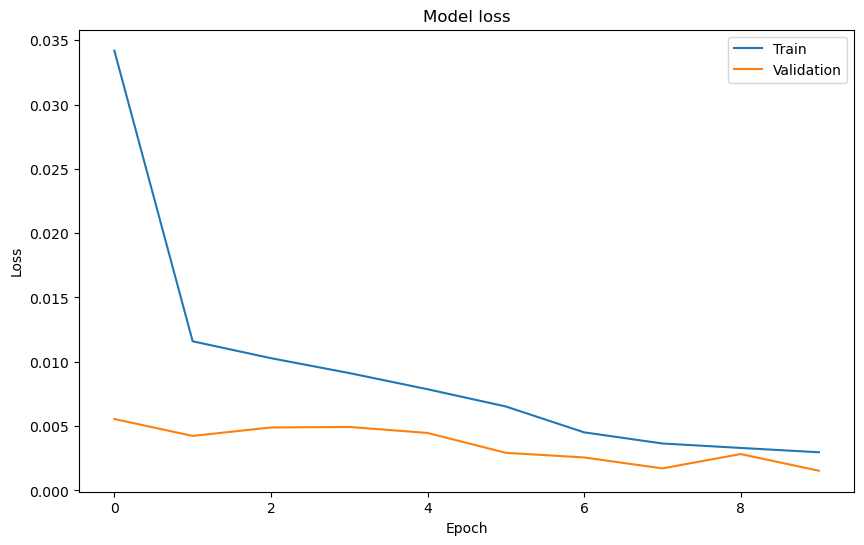

In [9]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback  # Import tqdm callback for progress bar

# Assuming `train` and `val` are your training and validation datasets respectively
# They should be in the form of tuples (X_train, y_train) and (X_val, y_val)

# Define a custom callback to update tqdm at the end of each epoch
class EpochUpdateTqdmCallback(TqdmCallback):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.sp(bar_format="{desc}: {percentage:3.0f}%|{bar}| {n:.0f}/{total_fmt} [{elapsed}<{remaining}]")

# Training the model with tqdm progress bar updating at the end of each epoch
history = model.fit(
    X_train, y_train,  # Replace with your actual training data
    validation_data=(X_val, y_val),  # Replace with your actual validation data
    epochs=10,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        EpochUpdateTqdmCallback()  # Use the custom callback for tqdm
    ]
)

# Visualizing training and validation loss
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
from keras.models import save_model

# Assuming 'model' is already defined as per your specifications

# Save the model with .h5 extension
save_model(model, '/mnt/sdc/Aditya/model_10secinterval_2_transformer.h5')

print("Model saved successfully.")


Model saved successfully.


In [11]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')
print(f'Test Loss: {test_loss}')

Train Loss: 0.0018394063226878643
Validation Loss: 0.0015359745593741536
Test Loss: 0.0018385261064395308


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493

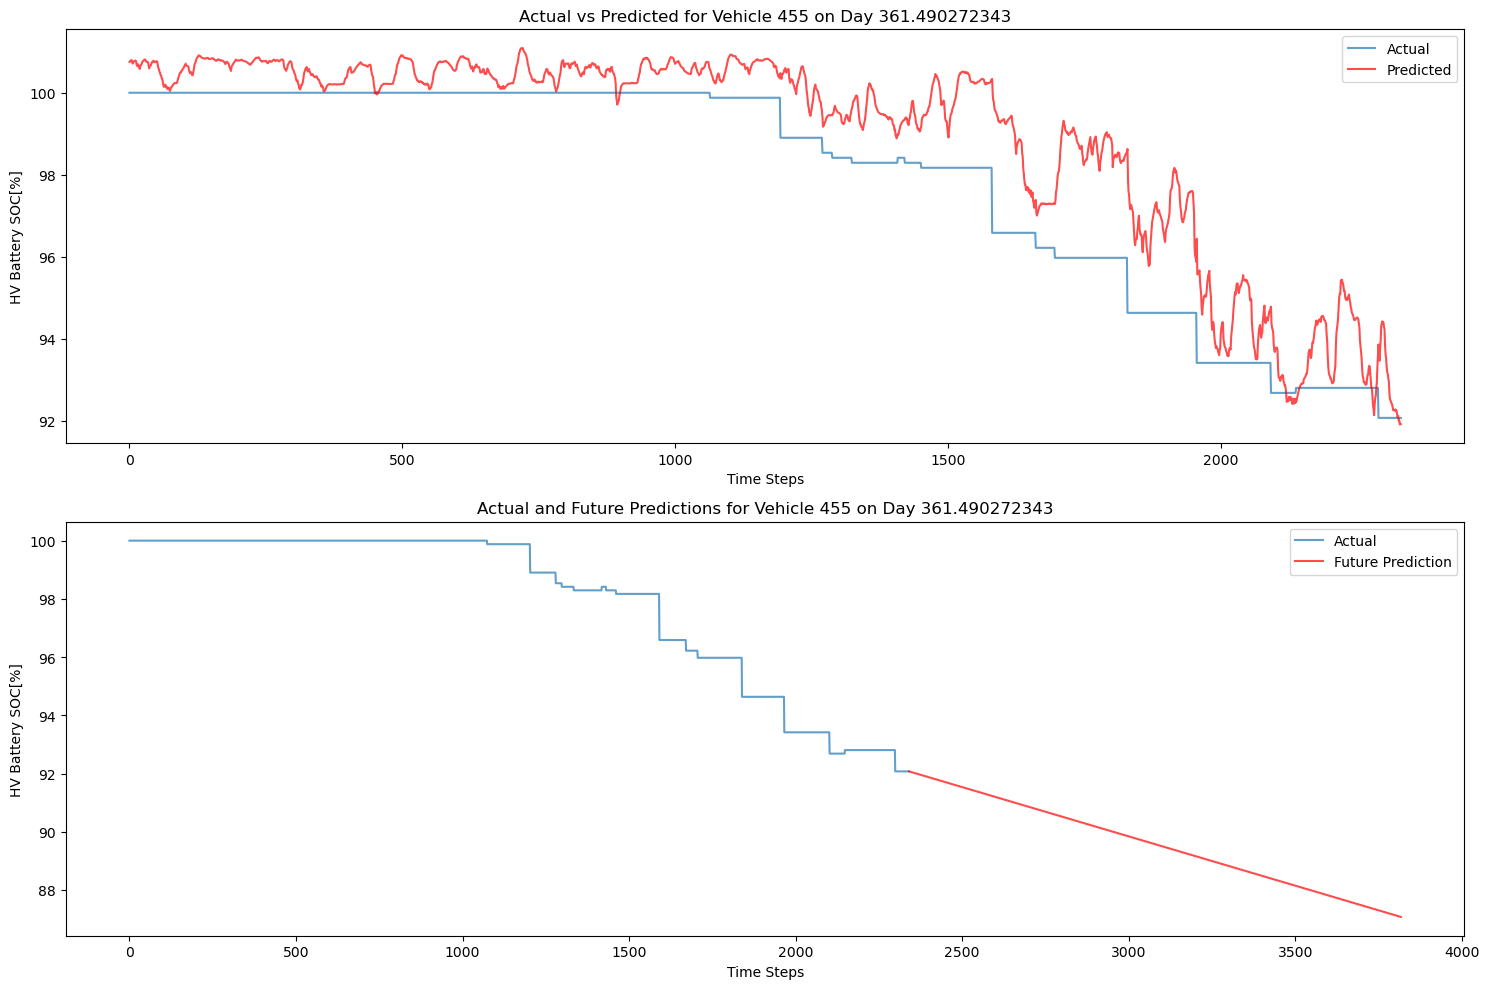

Predicted 1477 steps into the future.
Initial battery percentage: 92.07%
Final predicted battery percentage: 87.07%
Total change in battery percentage: -5.00%


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0, actual_values=None):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    initial_battery = scaler.inverse_transform(current_sequence)[:, target_col][-1]

    # Calculate average rate of decrease from actual data
    if actual_values is not None:
        avg_decrease = (actual_values[0] - actual_values[-1]) / len(actual_values)
    else:
        avg_decrease = 0.1  # fallback value if actual_values not provided

    step = 0
    while True:
        step += 1
        X = current_sequence.reshape(1, current_sequence.shape[0], len(features))
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]

        # Inverse transform to get the actual prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred_scaled
        next_pred = scaler.inverse_transform(dummy_array)[0, target_col]

        # Adjust prediction to follow the trend
        if step > 1:
            prev_pred = future_predictions[-1]
            next_pred = max(prev_pred - avg_decrease, next_pred - avg_decrease)

        future_predictions.append(next_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        next_features[target_col] = scaler.transform(dummy_array)[0, target_col]

        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features

        if abs(next_pred - initial_battery) >= threshold or next_pred <= 0:
            break

    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere
import numpy as np

def get_random_vehicle_day(df):
    # Get unique vehicles and days
    unique_vehicles = df['VehId']
    unique_days = df['DayNum']

    # Choose a random vehicle and day
    random_veh = np.random.choice(unique_vehicles)
    random_day = np.random.choice(unique_days)

    return random_veh, random_day

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i] for i in range(max_lookback, len(veh_data_scaled))])
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col, actual_values=actual_values)

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(actual_values[max_lookback:], label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493

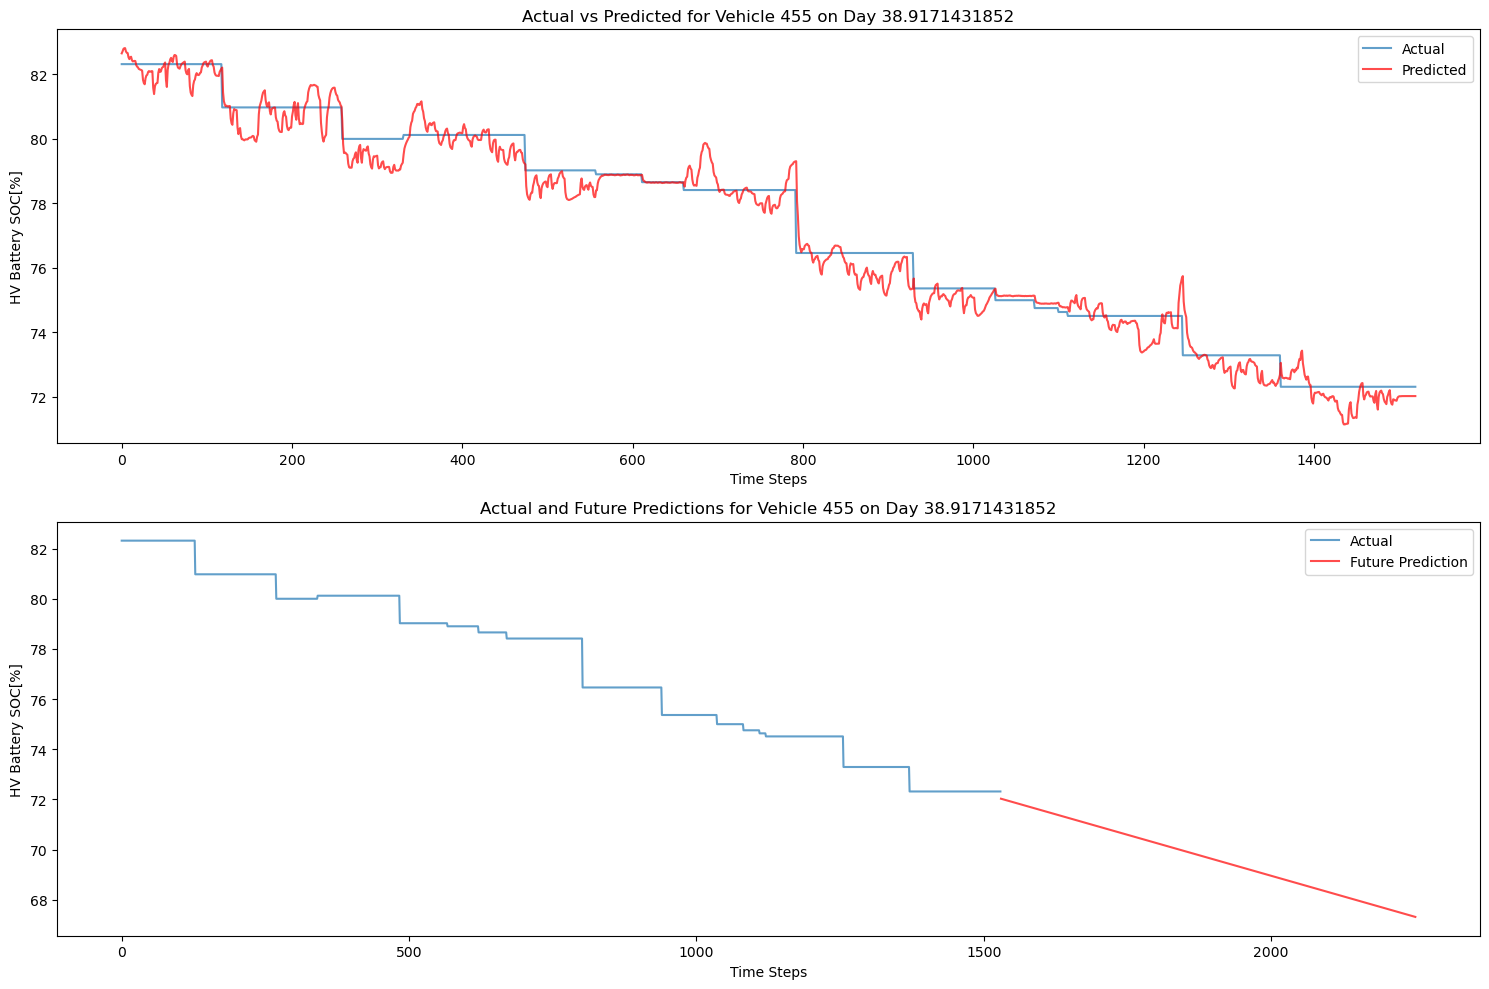

Predicted 722 steps into the future.
Initial battery percentage: 72.32%
Final predicted battery percentage: 67.32%
Total change in battery percentage: -5.00%


In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0, actual_values=None):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    initial_battery = scaler.inverse_transform(current_sequence)[:, target_col][-1]

    # Calculate average rate of decrease from actual data
    if actual_values is not None:
        avg_decrease = (actual_values[0] - actual_values[-1]) / len(actual_values)
    else:
        avg_decrease = 0.1  # fallback value if actual_values not provided

    step = 0
    while True:
        step += 1
        X = current_sequence.reshape(1, current_sequence.shape[0], len(features))
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]

        # Inverse transform to get the actual prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred_scaled
        next_pred = scaler.inverse_transform(dummy_array)[0, target_col]

        # Adjust prediction to follow the trend
        if step > 1:
            prev_pred = future_predictions[-1]
            next_pred = max(prev_pred - avg_decrease, next_pred - avg_decrease)

        future_predictions.append(next_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        next_features[target_col] = scaler.transform(dummy_array)[0, target_col]

        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features

        if abs(next_pred - initial_battery) >= threshold or next_pred <= 0:
            break

    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i] for i in range(max_lookback, len(veh_data_scaled))])
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col, actual_values=actual_values)

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(actual_values[max_lookback:], label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")

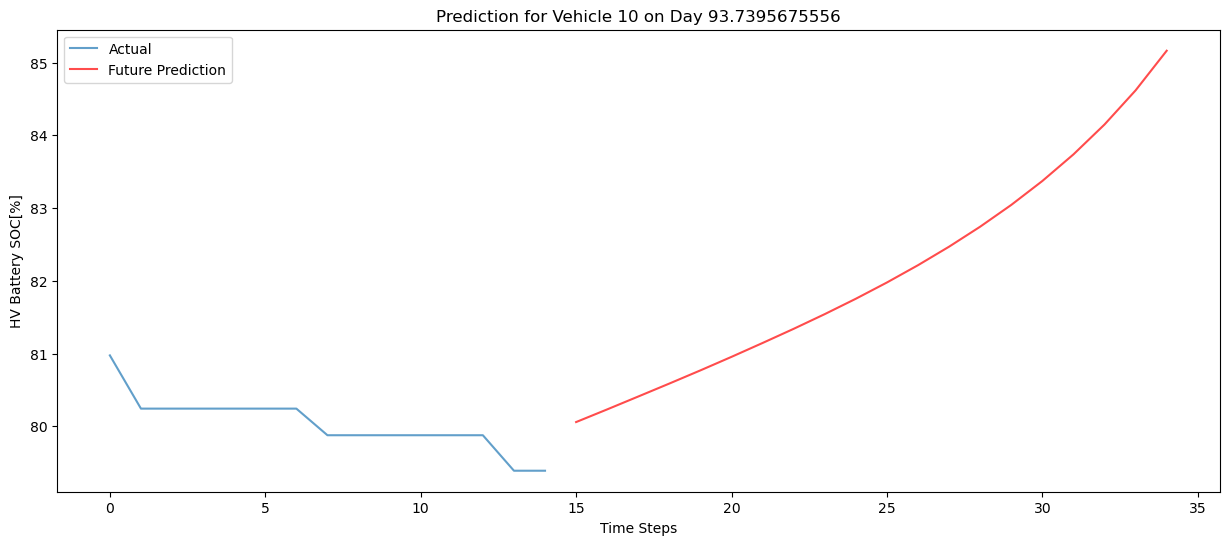

Predicted 20 steps into the future.
Initial battery percentage: 79.39%
Final predicted battery percentage: 85.16%
Total change in battery percentage: 5.77%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/mnt/sdc/Aditya/.conda/lib/python3.9/site-packages/sklearn/base.py:493

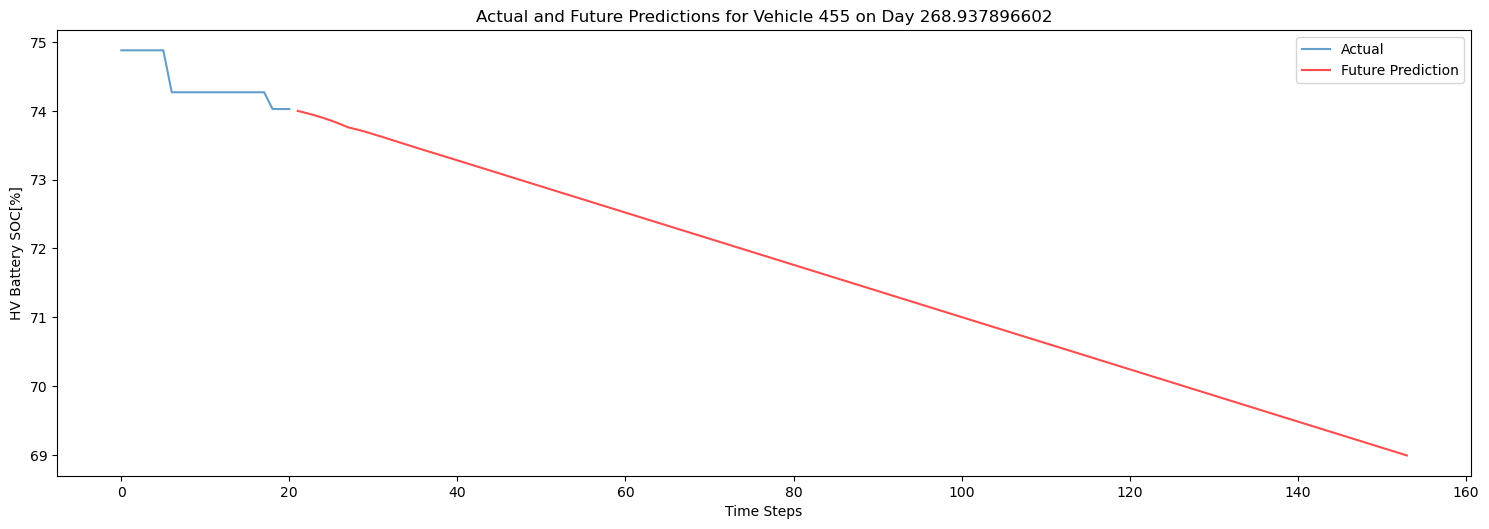

Predicted 133 steps into the future.
Initial battery percentage: 74.02%
Final predicted battery percentage: 68.99%
Total change in battery percentage: -5.03%


In [149]:
##best one till now

import numpy as np
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0, window_size=10):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    Uses a rolling average of recent changes to predict future values.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    # Reshape for inverse transform
    reshaped_sequence = current_sequence.reshape(-1, len(features))
    initial_battery = scaler.inverse_transform(reshaped_sequence)[-1, target_col]
    
    # Calculate initial average change
    inverse_transformed = scaler.inverse_transform(reshaped_sequence)
    changes = np.diff(inverse_transformed[:, target_col])
    avg_change = np.mean(changes[-window_size:])
    
    while True:
        X = current_sequence[:, target_col].reshape(1, initial_sequence.shape[0], 1)
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]
        
        # Apply the average change to the last known value
        last_value = scaler.inverse_transform(current_sequence[-1].reshape(1, -1))[0, target_col]
        next_pred = last_value + avg_change
        
        future_predictions.append(next_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred
        next_features[target_col] = scaler.transform(dummy_array)[0, target_col]
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features
        
        # Update the average change
        changes = np.append(changes[1:], next_pred - last_value)
        avg_change = np.mean(changes[-window_size:])
        
        if abs(next_pred - initial_battery) >= threshold:
            break
    
    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i, target_col] for i in range(max_lookback, len(veh_data_scaled))])
    X_pred = X_pred.reshape(X_pred.shape[0], max_lookback, 1)
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col)

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Step 1: next_pred=63.62, initial_battery=64.27
Step 2: next_pred=62.58, initial_battery=64.27
Step 3: next_pred=61.26, initial_battery=64.27
Step 4: next_pred=59.82, initial_battery=64.27
Step 5: next_pred=58.25, initial_battery=64.27


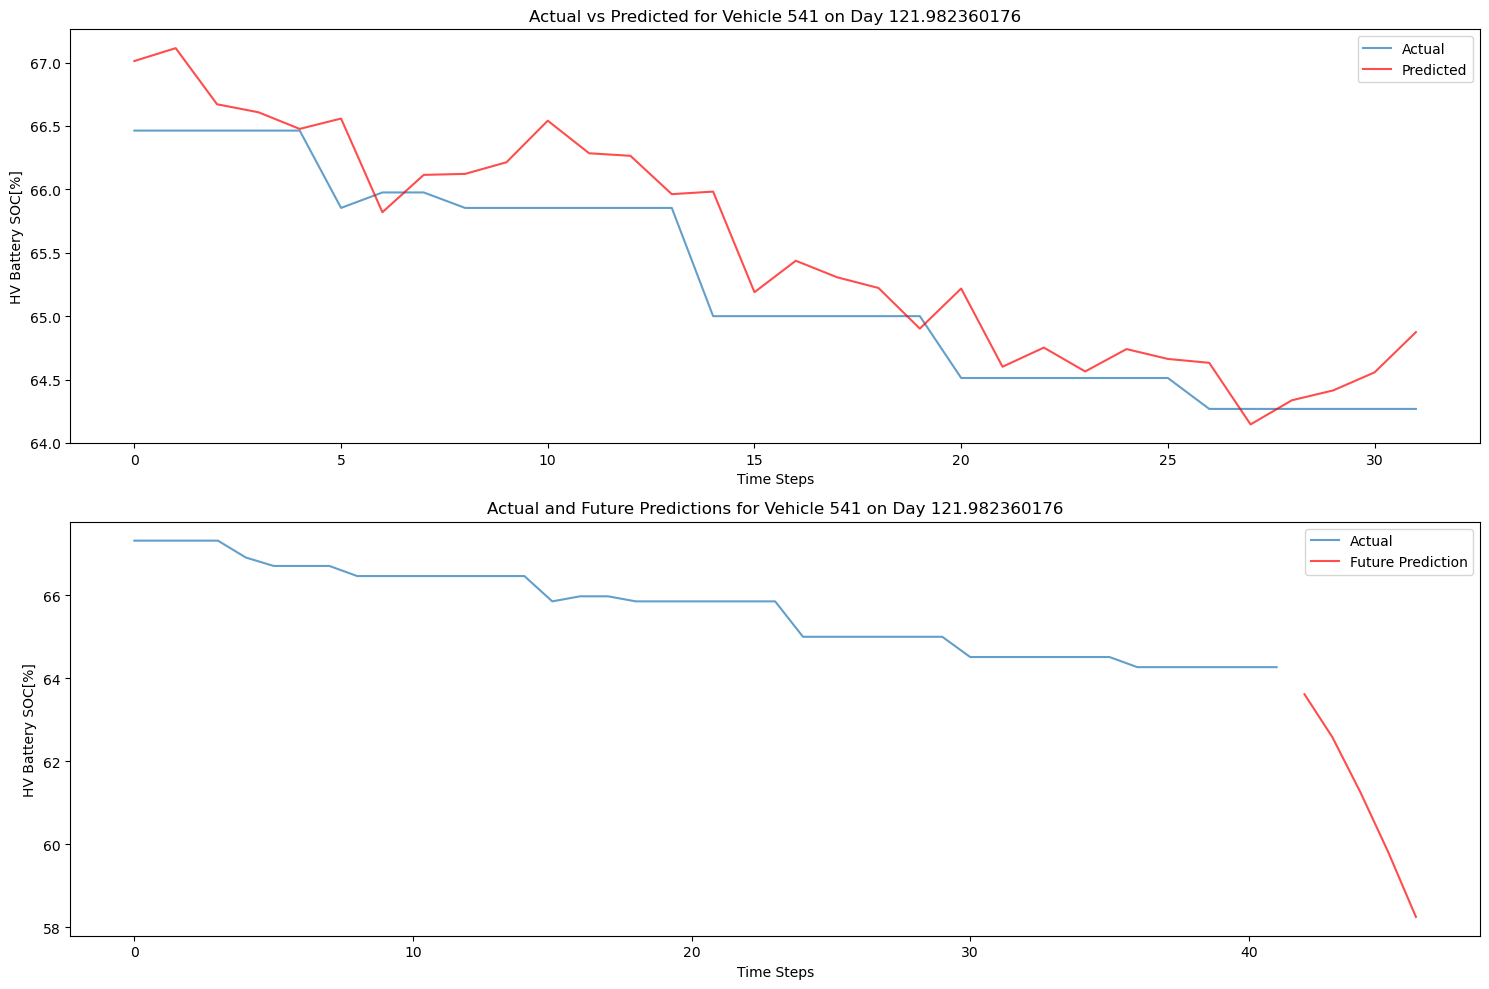

Predicted 5 steps into the future.
Initial battery percentage: 64.27%
Final predicted battery percentage: 58.25%
Total change in battery percentage: -6.02%


In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    initial_battery = scaler.inverse_transform(current_sequence)[:, target_col][-1]

    step = 0
    while True:
        step += 1
        X = current_sequence.reshape(1, current_sequence.shape[0], len(features))
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]

        # Inverse transform to get the actual prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred_scaled
        next_pred = scaler.inverse_transform(dummy_array)[0, target_col]

        future_predictions.append(next_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        next_features[target_col] = next_pred_scaled

        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features

        # Print debug information
        print(f"Step {step}: next_pred={next_pred:.2f}, initial_battery={initial_battery:.2f}")

        if abs(next_pred - initial_battery) >= threshold:
            break

    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i] for i in range(max_lookback, len(veh_data_scaled))])
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col)

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(actual_values[max_lookback:], label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")


In [95]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    initial_battery = scaler.inverse_transform(current_sequence)[:, target_col][-1]

    while True:
        X = current_sequence.reshape(1, current_sequence.shape[0], len(features))
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]

        # Inverse transform to get the actual prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred_scaled
        next_pred = scaler.inverse_transform(dummy_array)[0, target_col]

        future_predictions.append(next_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        next_features[target_col] = next_pred_scaled

        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features

        # Print debug information
        print(f"next_pred={next_pred:.2f}, initial_battery={initial_battery:.2f}")

        if abs(next_pred - initial_battery) >= threshold:
            break

    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i] for i in range(max_lookback, len(veh_data_scaled))])
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col)

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(actual_values[max_lookback:], label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
next_pred=92.92, initial_battery=92.93
next_pred=92.84, initial_battery=92.93
next_pred=92.82, initial_battery=92.93
next_pred=92.80, initial_battery=92.93
next_pred=92.77, initial_battery=92.93
next_pred=92.74, initial_battery=92.93
next_pred=92.70, initial_battery=92.93
next_pred=92.66, initial_battery=92.93
next_pred=92.61, initial_battery=92.93
next_pred=92.56, initial_battery=92.93
next_pred=92.51, initial_battery=92.93
next_pred=92.45, initial_battery=92.93
next_pred=92.38, initial_battery=92.93
next_pred=92.30, initial_battery=92.93
next_pred=92.22, initial_battery=92.93
next_pred=92.12, initial_battery=92.93
next_pred=92.02, initial_battery=92.93
next_pred=91.90, initial_battery=92.93
next_pred=91.78, initial_battery=92.93
next_pred=91.64, initial_battery=92.93
next_pred=91.49, initial_battery=92.93
next_pred=91.32, initial_battery=92.93
next_pred=91.15, initial_battery=92.93
next_pred=90.96, initial_battery=92.93
next_pred=90.77, initial_b

KeyboardInterrupt: 

In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def predict_until_threshold(model, initial_sequence, scaler, features, target_col, threshold=5.0, smoothing_factor=0.1):
    """
    Predict future values until the battery percentage changes by the threshold amount.
    """
    future_predictions = []
    current_sequence = initial_sequence.copy()
    initial_battery = scaler.inverse_transform(current_sequence)[:, target_col][-1]

    while True:
        X = current_sequence.reshape(1, current_sequence.shape[0], len(features))
        next_pred_scaled = model.predict(X, verbose=0)[0, 0]

        # Inverse transform to get the actual prediction
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, target_col] = next_pred_scaled
        next_pred = scaler.inverse_transform(dummy_array)[0, target_col]

        # Apply smoothing to the prediction
        last_value = scaler.inverse_transform(current_sequence[-1].reshape(1, -1))[:, target_col][0]
        smoothed_pred = (1 - smoothing_factor) * last_value + smoothing_factor * next_pred

        # Ensure smoothed_pred does not increase
        if smoothed_pred > last_value:
            smoothed_pred = last_value

        # Ensure the battery percentage decreases or stays the same
        if len(future_predictions) > 0:
            if smoothed_pred > future_predictions[-1]:
                smoothed_pred = future_predictions[-1]

        future_predictions.append(smoothed_pred)

        # Update the sequence
        next_features = current_sequence[-1].copy()
        next_features[target_col] = next_pred_scaled if next_pred_scaled <= smoothed_pred else smoothed_pred

        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_features

        # Print debug information
        print(f"next_pred={next_pred:.2f}, smoothed_pred={smoothed_pred:.2f}, last_value={last_value:.2f}, initial_battery={initial_battery:.2f}")

        if abs(smoothed_pred - initial_battery) >= threshold:
            break

    return np.array(future_predictions)

# Main execution
# Assuming df, model, scaler, features, target_col, and max_lookback are defined elsewhere

# Load the data (assuming the file provided contains the required data)
df = test

# Select a random vehicle and day
random_veh, random_day = get_random_vehicle_day(df)

# Filter data for the random vehicle and day
veh_data = df[(df['VehId'] == random_veh) & (df['DayNum'] == random_day)][features]

if len(veh_data) <= max_lookback:
    print("Not enough data points for this vehicle and day. Please run the function again.")
else:
    # Normalize the data
    veh_data_scaled = scaler.transform(veh_data)

    # Get the initial sequence
    initial_sequence = veh_data_scaled[-max_lookback:]

    # Predict values for the entire sequence
    X_pred = np.array([veh_data_scaled[i-max_lookback:i] for i in range(max_lookback, len(veh_data_scaled))])
    y_pred = model.predict(X_pred)

    # Inverse transform predictions
    dummy_array = np.zeros((len(y_pred), len(features)))
    dummy_array[:, target_col] = y_pred.flatten()
    y_pred_original = scaler.inverse_transform(dummy_array)[:, target_col]

    # Predict future values
    future_pred = predict_until_threshold(model, initial_sequence, scaler, features, target_col)

    # Get actual values
    actual_values = veh_data['HV Battery SOC[%]'].values

    # Plot the results
    plt.figure(figsize=(15, 10))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 1, 1)
    plt.plot(actual_values[max_lookback:], label='Actual', alpha=0.7)
    plt.plot(y_pred_original, label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs Predicted for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    # Plot 2: Actual and Future Predictions
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(actual_values)), actual_values, label='Actual', alpha=0.7)
    plt.plot(np.arange(len(actual_values), len(actual_values) + len(future_pred)), future_pred, label='Future Prediction', color='red', alpha=0.7)
    plt.title(f'Actual and Future Predictions for Vehicle {random_veh} on Day {random_day}')
    plt.xlabel('Time Steps')
    plt.ylabel('HV Battery SOC[%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Predicted {len(future_pred)} steps into the future.")
    print(f"Initial battery percentage: {actual_values[-1]:.2f}%")
    print(f"Final predicted battery percentage: {future_pred[-1]:.2f}%")
    print(f"Total change in battery percentage: {future_pred[-1] - actual_values[-1]:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
next_pred=92.82, smoothed_pred=92.80, last_value=92.80, initial_battery=92.80
next_pred=92.77, smoothed_pred=92.80, last_value=92.82, initial_battery=92.80
next_pred=92.67, smoothed_pred=92.76, last_value=92.77, initial_battery=92.80
next_pred=92.55, smoothed_pred=92.66, last_value=92.67, initial_battery=92.80
next_pred=92.42, smoothed_pred=92.54, last_value=92.55, initial_battery=92.80
next_pred=92.27, smoothed_pred=92.41, last_value=92.42, initial_battery=92.80
next_pred=92.11, smoothed_pred=92.26, last_value=92.27, initial_battery=92.80
next_pred=91.92, smoothed_pred=92.09, last_value=92.11, initial_battery=92.80
next_pred=91.71, smoothed_pred=91.90, last_value=91.92, initial_battery=92.80
next_pred=91.47, smoothed_pred=91.68, last_value=91.71, initial_battery=92.80
next_pred=91.23, smoothed_pred=91.45, last_value=91.47, initial_battery=92.80
next_pred=90.96, smoothed_pred=91.20, last_value=91.23, initial_battery=92.80
next_pred=90.69, smoothed_

KeyboardInterrupt: 